In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

SR_F_HZ = 1000
SQ_WAVE_F_HZ = 10

data = pd.read_csv('out/step_resp.csv')
data['Data'] -= data['Data'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)].min()  # OG Data contains values < 0.
data['Data'] /= data['Data'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)].max()
data['Data'].diff().gt(0.2)
data = data.tail(-data[data['Data'].diff().gt(0.1)].index[0]+1).reset_index(drop=True)
data['Time'] = np.arange(len(data)) / SR_F_HZ


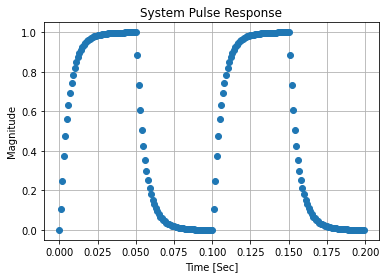

In [2]:
plt.plot(data['Time'][:200], data['Data'][:200], 'o')
plt.title('System Pulse Response')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.grid()

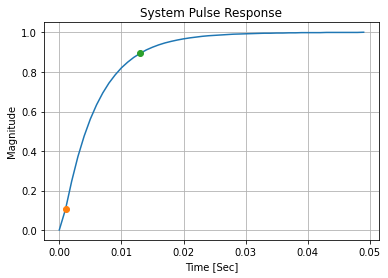

In [3]:
v10 = (data['Data'].max())*.1
v90 = (data['Data'].max())*.9

t10_i = (data['Data'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)] - v10).abs().argmin()
t90_i = (data['Data'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)] - v90).abs().argmin()

plt.plot(data['Time'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)], data['Data'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)])
plt.plot(data['Time'][t10_i], data['Data'][t10_i], 'o')
plt.plot(data['Time'][t90_i], data['Data'][t90_i], 'o')
plt.title('System Pulse Response')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.grid()

In [4]:
tr = data['Time'][t90_i] - data['Time'][t10_i]
print(f't_r = {tr * 1000} ms')

t_r = 12.0 ms


In [5]:
## White Box Analysis
c_1 = 100e-9
c_2 = 200e-9
r_1 = 10e3
r_2 = 10e3

p1 = 1/(2 * np.pi * c_1 * r_1)
p2 = 1/(2 * np.pi * c_2 * r_2)

print(f'Pole frequencies: {p1}Hz, {p2}Hz')

Pole frequencies: 159.15494309189532Hz, 79.57747154594766Hz


In [6]:
import numpy as np
from scipy.linalg import expm
from control import *
import matplotlib.pyplot as plt

s = tf('s')
hs_1 = 1 / ((r_1*c_1*r_2*c_2)*s*s + (r_1*c_1+r_1*c_2+r_2*c_2)*s + 1)
num_1, den_1 = tfdata(hs_1)


(array([0.80314212+0.j, 0.10220482+0.j]), array([-0.44487251+0.j]))

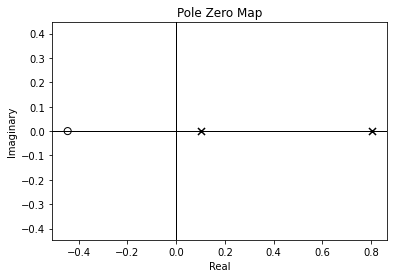

In [7]:
hz_1 = c2d(hs_1, 1/SR_F_HZ, 'zoh')
numz_1, denz_1 = tfdata(hz_1)
ss_2 = tf2ss(numz_1, denz_1)
pzmap(hz_1)

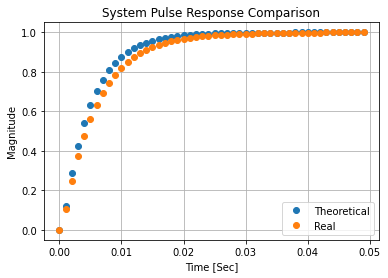

In [8]:
t, hz_out = step_response(hz_1)
plt.plot(t[:SR_F_HZ//SQ_WAVE_F_HZ//2], hz_out[:SR_F_HZ//SQ_WAVE_F_HZ//2], 'o', label='Theoretical')
plt.plot(data['Time'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)], data['Data'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)], 'o', label='Real')
plt.grid()
plt.title('System Pulse Response Comparison')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()

array([0.000e+00, 1.000e-03, 2.000e-03, ..., 4.997e+00, 4.998e+00,
       4.999e+00])